# COS40007 Portfolio - Improved Notebook
Dataset: Folds5x2_pp.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import display

# Load dataset
df = pd.read_csv("Folds5x2_pp.csv")
# Fix column names (remove hidden spaces/tabs)
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

Dataset shape: (9568, 5)
Columns in dataset: ['AT', 'V', 'AP', 'RH', 'PE']


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## 1. Basic EDA + Cleaning

In [2]:
df.info()
display(df.describe().T)

# Missing values check
print("Missing values per column:")
display(df.isnull().sum().to_frame("Missing"))

# If missing → impute with median
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Remove constant/irrelevant features
const_cols = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=const_cols, inplace=True)

print("Shape after cleaning:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


Missing values per column:


,Missing
AT,0
V,0
AP,0
RH,0
PE,0


Shape after cleaning: (9568, 5)


## 2. Outliers + Correlation

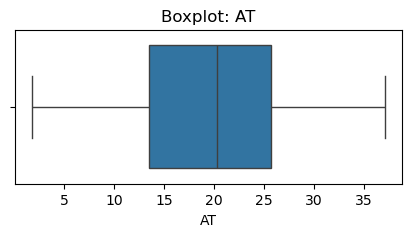

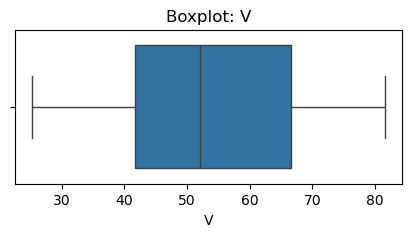

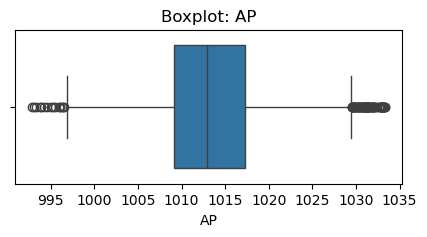

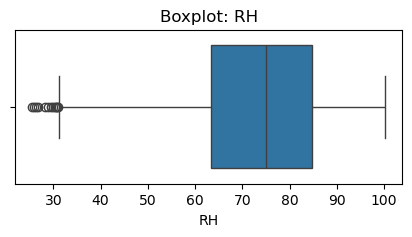

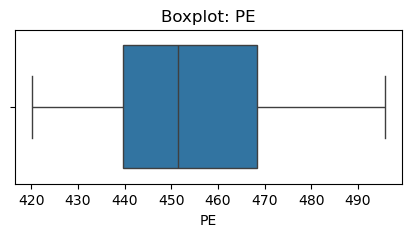

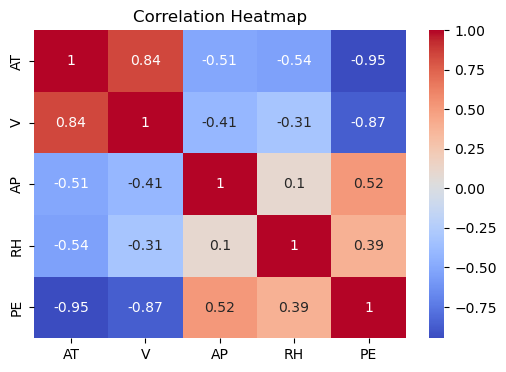

Dropped highly correlated features (excluding target): []
Remaining columns: ['AT', 'V', 'AP', 'RH', 'PE']


In [3]:
# Boxplots
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        plt.figure(figsize=(5,2))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot: {col}")
        plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Drop highly correlated features (>0.9), but NEVER drop the target column
target_col = "PE"
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.9) and col != target_col]

df.drop(columns=to_drop, inplace=True)
print("Dropped highly correlated features (excluding target):", to_drop)
print("Remaining columns:", df.columns.tolist())


## 3. Class Labelling (Discretization)

In [4]:
target_col = "PE"
print("Columns:", df.columns.tolist())
print("Exact repr of columns:")
for col in df.columns:
    print(repr(col))
df["target_label"] = pd.qcut(df[target_col], q=4, labels=False)

print("Class distribution:")
display(df["target_label"].value_counts(normalize=True).to_frame("Proportion"))


Columns: ['AT', 'V', 'AP', 'RH', 'PE']
Exact repr of columns:
'AT'
'V'
'AP'
'RH'
'PE'
Class distribution:


,Proportion
target_label,
2,0.250209
0,0.250105
1,0.249895
3,0.249791


## 4. Normalisation + Log Transform

In [5]:
features = [c for c in df.columns if c not in [target_col, "target_label"]]
scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

# Apply log transform on skewed features
for col in features:
    if df_scaled[col].skew() > 1:
        df_scaled[f"{col}_log"] = np.log1p(df_scaled[col])

# Integer categorisation (binning example for AT)
df_scaled["AT_binned"] = pd.cut(df_scaled["AT"], bins=4, labels=False)

print("Transformed dataset shape:", df_scaled.shape)
display(df_scaled.head())


Transformed dataset shape: (9568, 7)


,AT,V,AP,RH,PE,target_label,AT_binned
0,0.184986,0.274199,0.444197,0.863941,480.48,3,0
1,0.618414,0.589502,0.458055,0.652011,445.75,1,2
2,0.791218,0.561210,0.352883,0.219169,438.76,0,3
3,0.488952,0.432918,0.354615,0.686729,453.09,2,1
4,0.283003,0.272242,0.599852,0.960322,464.43,2,1


## 5. Feature Engineering

In [6]:
# Add polynomial, interaction, and aggregate features
df_scaled["features_mean"] = df_scaled[features].mean(axis=1)
df_scaled["AT_sq"] = df_scaled["AT"] ** 2
df_scaled["AT_x_V"] = df_scaled["AT"] * df_scaled["V"]

print("Added engineered features (AT_sq, AT_x_V, features_mean).")


Added engineered features (AT_sq, AT_x_V, features_mean).


## 6. Train-Test Split + Cross-Validation

In [7]:
# Define 5 feature sets
feature_sets = {
    "A_baseline": features,
    "B_binned": features + ["AT_binned"],
    "C_squared": features + ["AT_sq"],
    "D_interaction": features + ["AT_x_V"],
    "E_aggregate": features + ["features_mean"]
}

results = []
X_full = df_scaled.drop(columns=[target_col, "target_label"])
y = df_scaled["target_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

# Loop through each feature set to train and evaluate models
for name, feats in feature_sets.items():
    # Initialize a decision tree classifier with fixed max depth and random state
    model = DecisionTreeClassifier(max_depth=6, random_state=42)
    # Train the model using only the selected features
    model.fit(X_train[feats], y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test[feats])
    # Calculate accuracy score
    acc = accuracy_score(y_test, y_pred)
    # Calculate weighted F1 score (appropriate for imbalanced classes)
    f1 = f1_score(y_test, y_pred, average="weighted")
    # Store results for this feature set
    results.append([name, len(feats), acc, f1])

# Comparison table
results_df = pd.DataFrame(results, columns=["Feature_Set", "n_features", "Accuracy", "F1_score"])
display(results_df)


,Feature_Set,n_features,Accuracy,F1_score
0,A_baseline,4,0.834901,0.834902
1,B_binned,5,0.834901,0.834902
2,C_squared,5,0.834901,0.834902
3,D_interaction,5,0.817137,0.816256
4,E_aggregate,5,0.835946,0.837302


## 7. Grid Search (Hyperparameter Tuning)

Best feature set: E_aggregate


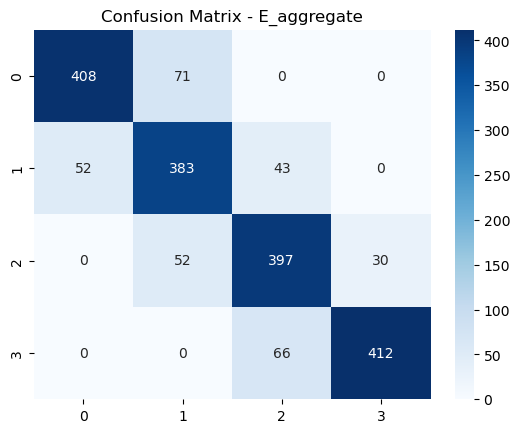

In [8]:
best_set = results_df.sort_values("Accuracy", ascending=False).iloc[0]["Feature_Set"]
print("Best feature set:", best_set)

best_feats = feature_sets[best_set]
best_model = DecisionTreeClassifier(max_depth=6, random_state=42)
best_model.fit(X_train[best_feats], y_train)
y_pred = best_model.predict(X_test[best_feats])

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_set}")
plt.show()
